In [16]:
import libsumo

SMALL_TRAFFIC_PATH = '../sumo_conf/small-traffic/small.sumocfg'
MEDIUM_TRAFFIC_PATH = '../sumo_conf/medium-traffic/medium.sumocfg'
LARGE_TRAFFIC_PATH = '../sumo_conf/large-traffic/large.sumocfg'


class SumoContext:
    def __init__(self, config_path):
        self.config_path = config_path

    def __enter__(self):
        libsumo.start(["sumo", "-c", self.config_path])
        return libsumo

    def __exit__(self, exc_type, exc_val, exc_tb):
        libsumo.close()

In [17]:
PHASES_COUNT = 8
MIN_TIME = 5
MAX_TIME = 60

def fitness(config, durations: list[int]):
    with SumoContext(config) as sumo:
        tf_id = sumo.trafficlight_getIDList()[0]
        logic = sumo.trafficlight_getAllProgramLogics(tf_id)[0]
        phases = logic.getPhases()
        for i in range(PHASES_COUNT):
            phases[i].duration = float(durations[i])
            phases[i].minDur = float(durations[i])
            phases[i].maxDur = float(durations[i])
        sumo.trafficlight.setProgramLogic(tf_id, logic)
        total_wt = 0
        total_veh = 0
        for i in range(3600):
            sumo.simulationStep()
            for veh_id in libsumo.vehicle.getIDList():
                if libsumo.vehicle.getSpeed(veh_id) < 0.1:
                    total_wt += 1
            total_veh += libsumo.simulation.getArrivedNumber()
        return total_wt / total_veh

with SumoContext(SMALL_TRAFFIC_PATH) as sumo:
    phases_duration = list(map(lambda x: x.duration, sumo.trafficlight_getAllProgramLogics(sumo.trafficlight_getIDList()[0])[0].getPhases()))
static_small = fitness(SMALL_TRAFFIC_PATH, phases_duration)
static_medium = fitness(MEDIUM_TRAFFIC_PATH, phases_duration)
static_large = fitness(LARGE_TRAFFIC_PATH, phases_duration)
print('DEFAULT AVG WAITING TIMES:')
print(f'SMALL TRAFFIC: {static_small}')
print(f'MEDIUM TRAFFIC: {static_medium}')
print(f'LARGE TRAFFIC: {static_large}')

DEFAULT AVG WAITING TIMES:
SMALL TRAFFIC: 60.18571428571428
MEDIUM TRAFFIC: 60.60283687943262
LARGE TRAFFIC: 185.7764331210191


In [18]:
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.soo.nonconvex.cmaes import CMAES
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.optimize import minimize
import numpy as np

class SumoStaticProblem(ElementwiseProblem):
    def __init__(self, config):
        super().__init__(n_var=PHASES_COUNT, n_obj=1, xl=np.array([MIN_TIME] * PHASES_COUNT), xu=np.array([MAX_TIME] * PHASES_COUNT))
        self.config = config

    def _evaluate(self, x, out, *args, **kwargs):
        out["F"] = fitness(self.config, x)
        
cmaes = CMAES()
ga = GA(eliminate_duplicates=True)
small_static_problem = SumoStaticProblem(SMALL_TRAFFIC_PATH)
medium_static_problem = SumoStaticProblem(MEDIUM_TRAFFIC_PATH)
large_static_problem = SumoStaticProblem(LARGE_TRAFFIC_PATH)

In [20]:
cmaes_static_small = minimize(problem=small_static_problem, algorithm=cmaes, termination=('n_eval', 1000), seed=1)
print("Best solution found for CMAES: \nX = %s\nF = %s" % (cmaes_static_small.X, cmaes_static_small.F))
ga_static_small = minimize(problem=small_static_problem, algorithm=ga, termination=('n_eval', 1000), seed=1)
print("Best solution found for GA: \nX = %s\nF = %s" % (ga_static_small.X, ga_static_small.F))
cmaes_static_medium = minimize(problem=medium_static_problem, algorithm=cmaes, termination=('n_eval', 1000), seed=1)
print("Best solution found for CMAES: \nX = %s\nF = %s" % (cmaes_static_medium.X, cmaes_static_medium.F))
ga_static_medium = minimize(problem=medium_static_problem, algorithm=ga, termination=('n_eval', 1000), seed=1)
print("Best solution found for GA: \nX = %s\nF = %s" % (ga_static_medium.X, ga_static_medium.F))
cmaes_static_large = minimize(problem=large_static_problem, algorithm=cmaes, termination=('n_eval', 1000), seed=1)
print("Best solution found for CMAES: \nX = %s\nF = %s" % (cmaes_static_large.X, cmaes_static_large.F))
ga_static_large = minimize(problem=large_static_problem, algorithm=ga, termination=('n_eval', 1000), seed=1)
print("Best solution found for GA: \nX = %s\nF = %s" % (ga_static_large.X, ga_static_large.F))

Best solution found for CMAES: 
X = [5.02487879 5.00410612 5.00964768 5.09415423 5.0004839  5.05746478
 5.05230303 5.00419842]
F = [12.84313725]
Best solution found for GA: 
X = [ 7.41640536  7.01551702 16.39852925  6.09885137 13.14048137  5.30671226
 11.24568481  5.1630346 ]
F = [23.14647887]
Best solution found for CMAES: 
X = [5.00606123 5.01307224 7.91773518 5.00867496 5.14866129 5.00289196
 7.42440791 5.00932639]
F = [15.08123249]
Best solution found for GA: 
X = [ 9.32020252  5.41625304 25.21183604  7.1313655  10.87757542  5.00085138
 17.47791298  5.98450256]
F = [28.87694484]
Best solution found for CMAES: 
X = [ 8.92990753  5.09024383 17.7270879   5.09727093  9.03892572  5.01447154
 17.50690251  5.00052046]
F = [27.45906268]
Best solution found for GA: 
X = [11.46034756  7.90345387 32.96876233  5.11889759 12.93734701  5.36863292
 41.10971909  5.42526608]
F = [46.54576464]


In [21]:
RED = 'r'
YELLOW = 'y'
GREEN = 'G'
YELLOW_TIME = 3

In [22]:
def function_fitness(config, min_cars, min_time, max_time, change_ratio):
    with SumoContext(config) as sumo:
        tf_id = sumo.trafficlight_getIDList()[0]
        logic = sumo.trafficlight_getAllProgramLogics(tf_id)[0]
        phase = logic.phases[0]
        current_state = [s for i, s in enumerate(phase.state) if i % 5 != 4]
        current_time = [0 for i in range(len(current_state))]
        current_change = ['' for i in range(len(current_state))]
        lanes = [i for i in range(16)]
        base_conflicts = {
            0: [5],
            1: [5, 6, 11, 12, 13, 14, 15],
            2: [5, 6, 7, 11, 13, 14, 15],
            3: [5, 6, 7, 9, 10, 14, 15]
        }
        total_wt = 0
        total_veh = 0
        
        def get_conflicts(lane_id):
            if base_conflicts.get(lane_id) is not None:
                return base_conflicts[lane_id]
            return [(i + 4 * (lane_id // 4)) % 16 for i in base_conflicts[lane_id % 4]]

        def lane_to_light(lane_id):
            if lane_id < 3: return [lane_id]
            if lane_id == 3: return [lane_id, lane_id + 1]
            if lane_id < 7: return [lane_id + 1]
            if lane_id == 7: return [lane_id + 1, lane_id + 2]
            if lane_id < 11: return [lane_id + 2]
            if lane_id == 11: return [lane_id + 2, lane_id + 3]
            if lane_id < 15: return [lane_id + 3]
            return [lane_id + 3, lane_id + 4]

        def change_state(lane, state):
            current_state[lane] = state
            for light_id in lane_to_light(lane):
                phase.state = phase.state[:light_id] + state + phase.state[light_id + 1:]
                sumo.trafficlight.setProgramLogic(tf_id, logic)
            
        def change_to_yellow(lane, change_to):
            change_state(lane, YELLOW)
            current_change[lane] = change_to
            current_time[lane] = 0
            
        def should_be_candidate(lane, lane_waiting):
            if lane_waiting > min_cars or current_time[lane] > max_time:
                conflicts = get_conflicts(lane)
                for conflict in conflicts:
                    if current_change[conflict] == GREEN: break
                    if current_state[conflict] == GREEN:
                        if current_time[conflict] < min_time: break
                        conflict_waiting = sumo.lane.getLastStepVehicleNumber(str(conflict))
                        if conflict_waiting > 0 and lane_waiting > 0 and conflict_waiting / lane_waiting > change_ratio: break
                else:
                    return True
            return False
        
        def change_candidates(step_changes):
            step_changes.sort(key=lambda x: x[1], reverse=True)
            for lane, _ in step_changes:
                if current_state[lane] == YELLOW: continue
                change_to_yellow(lane, GREEN)
                for conflict in get_conflicts(lane):
                    if current_state[conflict] != GREEN: continue
                    change_to_yellow(conflict, RED)
                    
        def get_waiting_vehicles():
            nonlocal total_wt, total_veh
            for veh_id in sumo.vehicle.getIDList():
                if sumo.vehicle.getSpeed(veh_id) < 0.1:
                    total_wt += 1
            total_veh += sumo.simulation.getArrivedNumber()
                    
        def update_times():
            for lane in lanes:
                if current_state[lane] == YELLOW and current_time[lane] == YELLOW_TIME:
                    change_state(lane, current_change[lane])
                    current_change[lane] = ''
                    current_time[lane] = 0
                else: current_time[lane] += 1
        
        for i in range(3600):
            # go through all lanes and check if they are candidates for changing
            step_changes = []
            for lane in lanes:
                if current_state[lane] == RED:
                    lane_waiting = sumo.lane.getLastStepVehicleNumber(str(lane))
                    if should_be_candidate(lane, lane_waiting):
                        step_changes.append((lane, lane_waiting))
                        
            # change the state of the candidates, on conflict change only the light on the line that has longer queue 
            change_candidates(step_changes)

            sumo.simulationStep()
            
            get_waiting_vehicles()
            
            # update time for lights, change yellow if needed
            update_times()
        
    return total_wt / total_veh

In [23]:
function_fitness(LARGE_TRAFFIC_PATH, min_cars=3, min_time=5, max_time=60, change_ratio=0.1)

22.4912676056338

In [24]:
class SumoDynamicProblem(ElementwiseProblem):
    def __init__(self, config):
        super().__init__(n_var=4, n_obj=1, xl=np.array([0, 5, 30, 0.1]), xu=np.array([10, 60, 300, 10]))
        self.config = config

    def _evaluate(self, x, out, *args, **kwargs):
        out["F"] = function_fitness(config=self.config, min_cars=x[0], min_time=x[1], max_time=x[2], change_ratio=x[3])

In [25]:
small_dynamic_problem = SumoDynamicProblem(SMALL_TRAFFIC_PATH)
medium_dynamic_problem = SumoDynamicProblem(MEDIUM_TRAFFIC_PATH)
large_dynamic_problem = SumoDynamicProblem(LARGE_TRAFFIC_PATH)

In [26]:
cmaes_medium = minimize(problem=medium_dynamic_problem, algorithm=cmaes, seed=1, termination=('n_eval', 1000), verbose=True)
print("Best solution found for CMAES: \nX = %s\nF = %s" % (cmaes_medium.X, cmaes_medium.F))

n_gen  |  n_eval  |     f_avg     |     f_min     |     sigma     | min_std  | max_std  |   axis  
     1 |       20 |  5.204755E+01 |  1.108287E+01 |  0.1000000000 |  0.10000 |  0.10000 |  1.00004
     2 |       28 |  1.508566E+01 |  9.9396067416 |  0.1036672750 |  0.09605 |  0.11429 |  1.46614
     3 |       36 |  1.213533E+01 |  9.9396067416 |  0.0860031391 |  0.07062 |  0.09340 |  1.51907
     4 |       44 |  1.209764E+01 |  9.9396067416 |  0.0833647997 |  0.05975 |  0.09794 |  1.89530
     5 |       52 |  1.069151E+01 |  9.9396067416 |  0.0776259636 |  0.05130 |  0.09027 |  1.94218
     6 |       60 |  1.051937E+01 |  9.9396067416 |  0.0670077735 |  0.04053 |  0.08216 |  2.23786
     7 |       68 |  1.145886E+01 |  9.9396067416 |  0.0587504058 |  0.02920 |  0.07145 |  2.82445
     8 |       76 |  1.066592E+01 |  9.9396067416 |  0.0542772291 |  0.02262 |  0.06946 |  3.44552
     9 |       84 |  1.035104E+01 |  9.9396067416 |  0.0584695782 |  0.02185 |  0.07418 |  3.83673
    10 |  

In [27]:
ga_medium = minimize(problem=medium_dynamic_problem, algorithm=ga, termination=('n_eval', 1000), seed=1, verbose=True)
print("Best solution found for GA: \nX = %s\nF = %s" % (ga_medium.X, ga_medium.F))

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |      100 |  4.619367E+01 |  4.8137254902
     2 |      200 |  1.824799E+01 |  4.8137254902
     3 |      300 |  1.229192E+01 |  3.2783216783
     4 |      400 |  8.9213324901 |  3.2783216783
     5 |      500 |  5.3875583590 |  3.2783216783
     6 |      600 |  4.2414545283 |  3.1162464986
     7 |      700 |  3.6504839143 |  3.0798319328
     8 |      800 |  3.3481449871 |  3.0419580420
     9 |      900 |  3.2381894968 |  3.0419580420
    10 |     1000 |  3.1827564201 |  2.9076923077
Best solution found for GA: 
X = [  0.73463271   5.75444515 142.61428933   1.65543303]
F = [2.90769231]


In [28]:
cmaes_small = minimize(problem=small_dynamic_problem, algorithm=cmaes, seed=1,termination=('n_eval', 1000), verbose=True)
print("Best solution found for CMAES: \nX = %s\nF = %s" % (cmaes_small.X, cmaes_small.F))

n_gen  |  n_eval  |     f_avg     |     f_min     |     sigma     | min_std  | max_std  |   axis  
     1 |       20 |  4.845860E+01 |  1.117087E+01 |  0.1000000000 |  0.10000 |  0.10000 |  1.00004
     2 |       28 |  1.430006E+01 |  9.6685393258 |  0.1036672750 |  0.09605 |  0.11429 |  1.46614
     3 |       36 |  1.174186E+01 |  9.6685393258 |  0.0858015802 |  0.07076 |  0.09330 |  1.50325
     4 |       44 |  1.063129E+01 |  9.6685393258 |  0.0842291906 |  0.06428 |  0.10209 |  1.74511
     5 |       52 |  1.020729E+01 |  9.6685393258 |  0.0895668796 |  0.06600 |  0.11770 |  1.89979
     6 |       60 |  1.092721E+01 |  9.6685393258 |  0.0747347468 |  0.04581 |  0.10011 |  2.36078
     7 |       68 |  1.092147E+01 |  9.6685393258 |  0.0711258963 |  0.03655 |  0.09102 |  2.62848
     8 |       76 |  1.059298E+01 |  9.6685393258 |  0.0692235862 |  0.03362 |  0.09864 |  3.28993
     9 |       84 |  1.077349E+01 |  9.6685393258 |  0.0626065255 |  0.02692 |  0.09348 |  4.26460
    10 |  

In [29]:
ga_small = minimize(problem=small_dynamic_problem, algorithm=ga, termination=('n_eval', 1000), seed=1, verbose=True)
print("Best solution found for GA: \nX = %s\nF = %s" % (ga_small.X, ga_small.F))

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |      100 |  4.453947E+01 |  4.0586592179
     2 |      200 |  1.889614E+01 |  4.0586592179
     3 |      300 |  1.201184E+01 |  3.1983240223
     4 |      400 |  8.2567009365 |  2.1480446927
     5 |      500 |  4.4392469292 |  1.9469273743
     6 |      600 |  3.0968148178 |  1.9047619048
     7 |      700 |  2.4713511885 |  1.8882681564
     8 |      800 |  2.0227687276 |  1.7402234637
     9 |      900 |  1.9336384051 |  1.6927374302
    10 |     1000 |  1.8774825126 |  1.6340782123
Best solution found for GA: 
X = [  0.64689476   7.4996957  218.81907642   3.08233139]
F = [1.63407821]


In [30]:
cmaes_large = minimize(problem=large_dynamic_problem, algorithm=cmaes, seed=1,termination=('n_eval', 1000), verbose=True)
print("Best solution found for CMAES: \nX = %s\nF = %s" % (cmaes_large.X, cmaes_large.F))

n_gen  |  n_eval  |     f_avg     |     f_min     |     sigma     | min_std  | max_std  |   axis  
     1 |       20 |  4.564693E+01 |  1.470784E+01 |  0.1000000000 |  0.10000 |  0.10000 |  1.00004
     2 |       28 |  1.343738E+01 |  9.7887640449 |  0.0974272891 |  0.08902 |  0.10105 |  1.37527
     3 |       36 |  9.7979293142 |  8.8040426727 |  0.1039593780 |  0.09191 |  0.10813 |  1.56071
     4 |       44 |  9.8997815221 |  7.9343065693 |  0.1036001646 |  0.08674 |  0.11278 |  1.66336
     5 |       52 |  1.034723E+01 |  7.9343065693 |  0.1105757597 |  0.09611 |  0.13318 |  2.11846
     6 |       60 |  9.0226103495 |  7.5991016283 |  0.1084057955 |  0.08748 |  0.12312 |  1.95610
     7 |       68 |  9.3420428974 |  7.1422947132 |  0.1083901621 |  0.08009 |  0.12218 |  2.04528
     8 |       76 |  1.328516E+01 |  7.1422947132 |  0.0932870000 |  0.06615 |  0.10374 |  2.14885
     9 |       84 |  1.020244E+01 |  7.1422947132 |  0.0811965649 |  0.05567 |  0.08618 |  2.13233
    10 |  

In [31]:
ga_large = minimize(problem=large_dynamic_problem, algorithm=ga, termination=('n_eval', 1000), seed=1, verbose=True)
print("Best solution found for GA: \nX = %s\nF = %s" % (ga_large.X, ga_large.F))

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |      100 |  4.493500E+01 |  1.018304E+01
     2 |      200 |  2.160914E+01 |  1.018304E+01
     3 |      300 |  1.561709E+01 |  9.2614084507
     4 |      400 |  1.214034E+01 |  8.7355418304
     5 |      500 |  9.8582430835 |  8.0084127874
     6 |      600 |  9.1133886112 |  7.3415869443
     7 |      700 |  8.7419894843 |  7.3415869443
     8 |      800 |  8.4498187928 |  7.3415869443
     9 |      900 |  8.2112262172 |  7.3415869443
    10 |     1000 |  8.0152332997 |  7.1028089888
Best solution found for GA: 
X = [  0.36900217   5.33461765 186.99640002   2.53199748]
F = [7.10280899]


<BarContainer object of 15 artists>

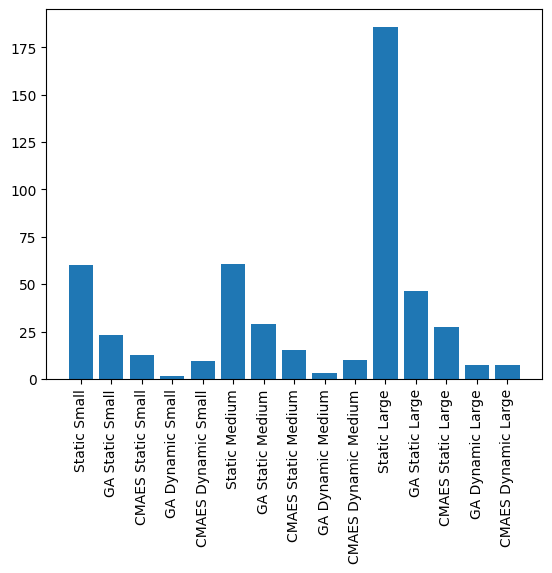

In [33]:
import matplotlib.pyplot as plt

x = ['Static Small', 'GA Static Small', 'CMAES Static Small', 'GA Dynamic Small', 'CMAES Dynamic Small', 'Static Medium', 'GA Static Medium', 'CMAES Static Medium', 'GA Dynamic Medium', 'CMAES Dynamic Medium', 'Static Large', 'GA Static Large', 'CMAES Static Large', 'GA Dynamic Large', 'CMAES Dynamic Large']
y = [static_small, ga_static_small.F[0], cmaes_static_small.F[0], ga_small.F[0], cmaes_small.F[0], static_medium, ga_static_medium.F[0], cmaes_static_medium.F[0], ga_medium.F[0], cmaes_medium.F[0], static_large, ga_static_large.F[0], cmaes_static_large.F[0], ga_large.F[0], cmaes_large.F[0]]
plt.xticks(rotation=90)
plt.bar(x, y)